In [2]:
%matplotlib inline

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
df = pd.read_csv('data/Consumo_cerveja.csv', 
                 decimal=',', 
                 thousands='.', 
                 header=0, 
                 names=['date','median_temp','min_temp','max_temp','precip','weekend','consumption'], 
                 parse_dates=['date'], 
                 nrows=365)


# Questions

- Relation between date and precipitation
- Weekend vs consumption?
- Weekday vs comsumption?

In [22]:
df.corr()#.style.background_gradient()

,median_temp,min_temp,max_temp,precip,weekend,consumption
median_temp,1.000000,0.862752,0.922513,0.024416,-0.050803,0.574615
min_temp,0.862752,1.000000,0.672929,0.098625,-0.059534,0.392509
max_temp,0.922513,0.672929,1.000000,-0.049305,-0.040258,0.642672
precip,0.024416,0.098625,-0.049305,1.000000,0.001587,-0.193784
weekend,-0.050803,-0.059534,-0.040258,0.001587,1.000000,0.505981
consumption,0.574615,0.392509,0.642672,-0.193784,0.505981,1.000000


In [23]:
df.corr().style.background_gradient()

,median_temp,min_temp,max_temp,precip,weekend,consumption
median_temp,1,0.862752,0.922513,0.0244158,-0.050803,0.574615
min_temp,0.862752,1,0.672929,0.0986255,-0.0595337,0.392509
max_temp,0.922513,0.672929,1,-0.0493052,-0.0402584,0.642672
precip,0.0244158,0.0986255,-0.0493052,1,0.00158677,-0.193784
weekend,-0.050803,-0.0595337,-0.0402584,0.00158677,1,0.505981
consumption,0.574615,0.392509,0.642672,-0.193784,0.505981,1


# Method Chaining

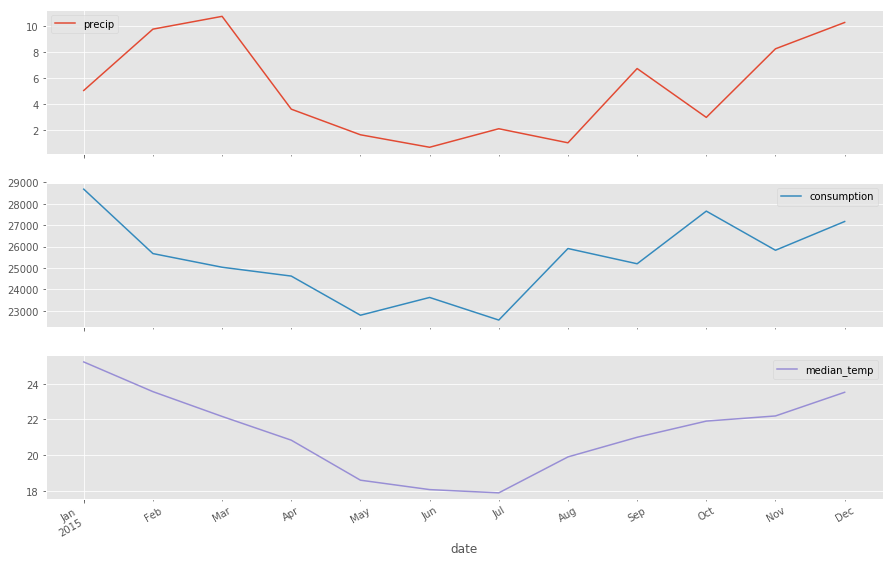

In [4]:
resampler = df.set_index('date').resample('M')
resampler[['precip', 'consumption', 'median_temp']].mean().plot(subplots=True);

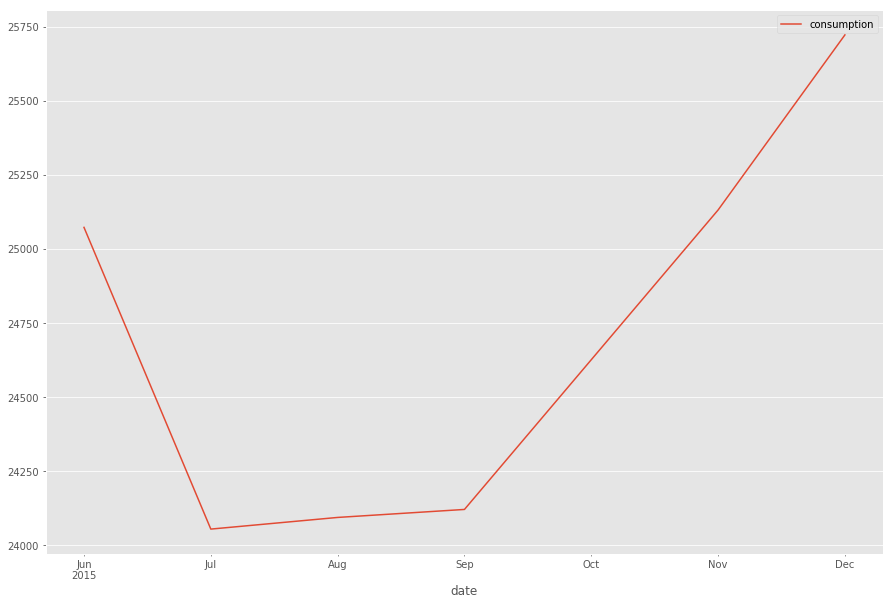

In [25]:
resampler.mean().rolling(6).mean()[['consumption']].plot()

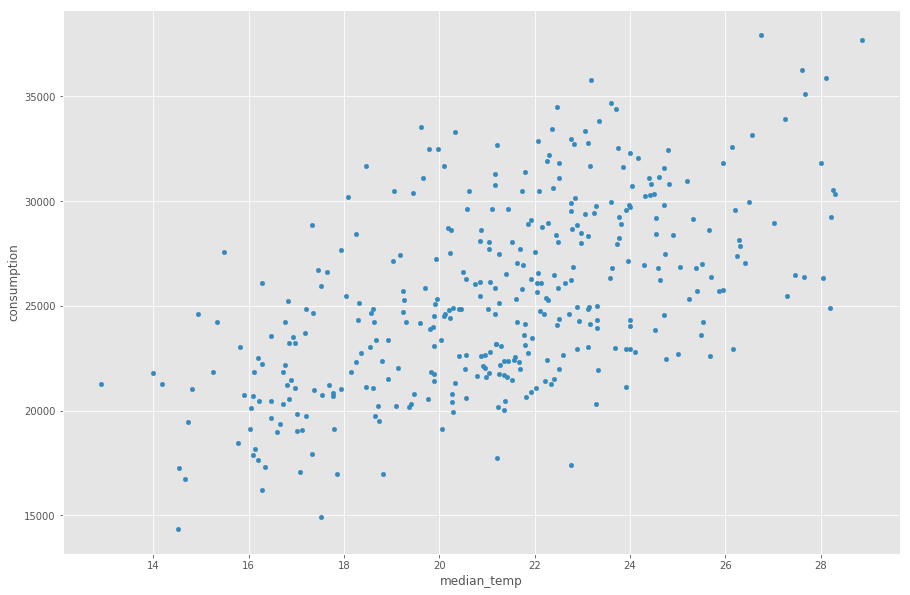

In [6]:
df.plot(kind='scatter', x='median_temp', y='consumption')

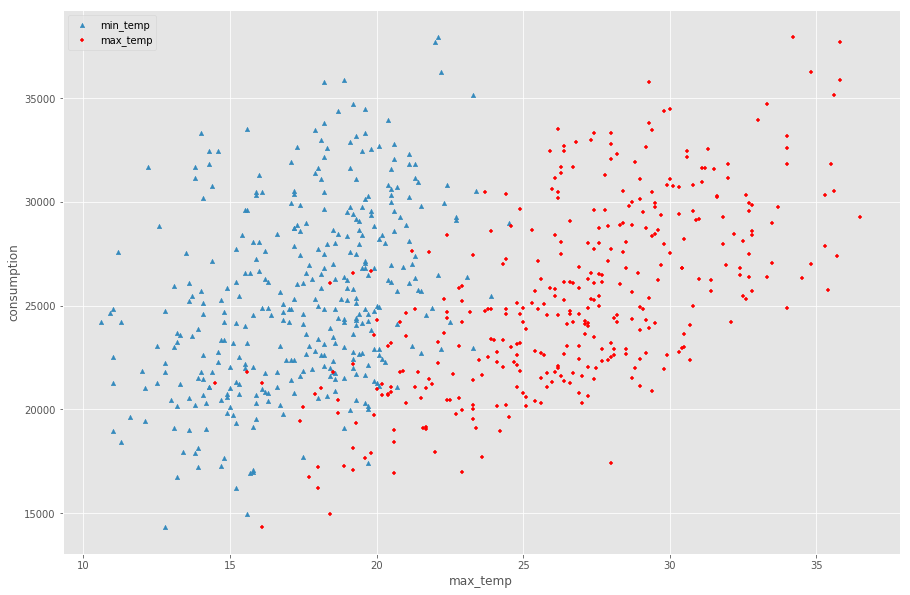

In [7]:
ax = df.plot(kind='scatter', x='min_temp', y='consumption', marker='^', label='min_temp');
df.plot(kind='scatter', x='max_temp', y='consumption', c='red', marker='+', ax=ax, label='max_temp');

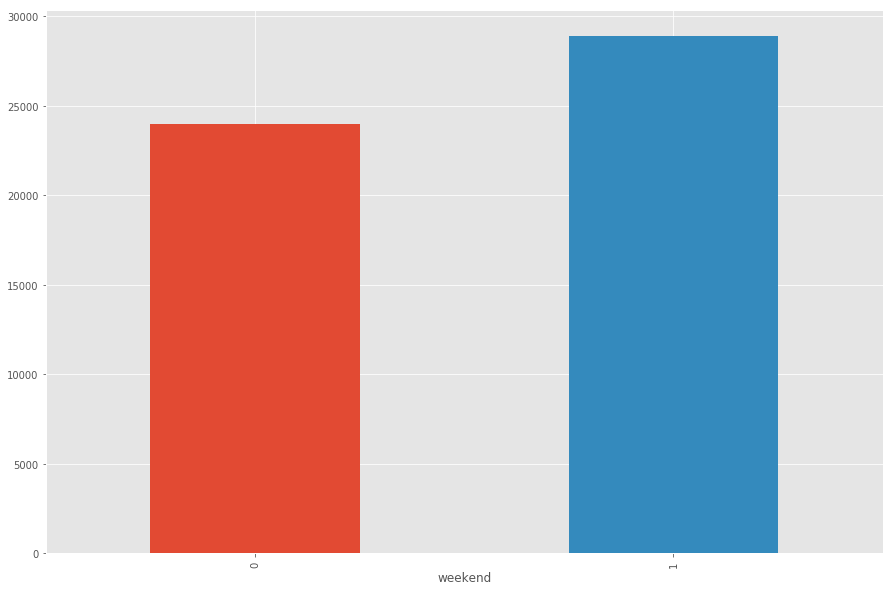

In [8]:
df.groupby('weekend').consumption.mean().plot(kind='bar');

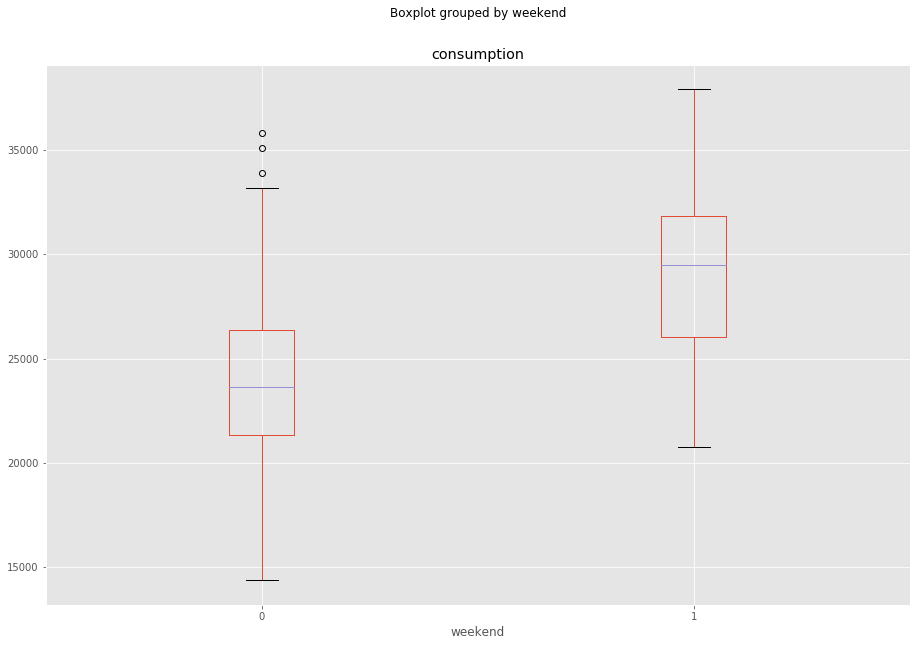

In [9]:
df.boxplot(column='consumption', by='weekend')

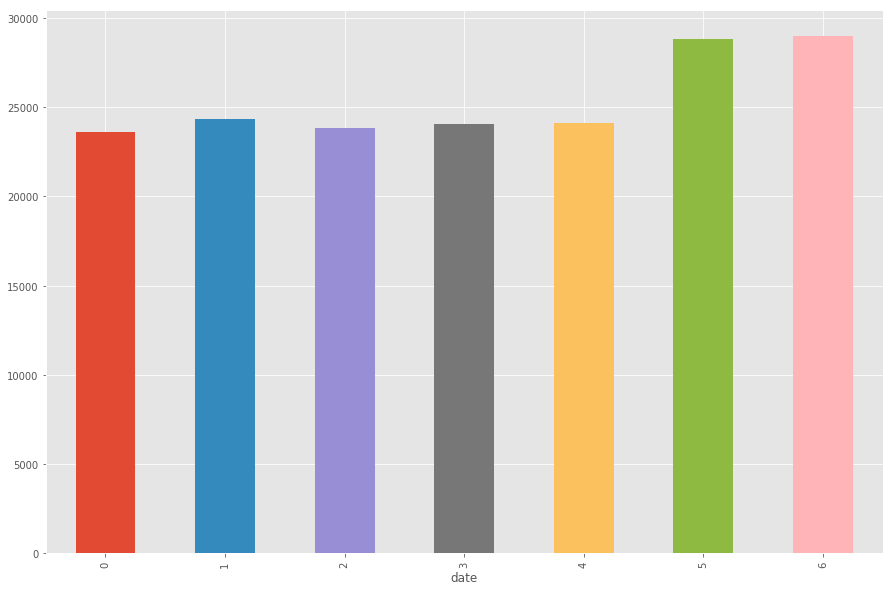

In [10]:
df.groupby(df.date.dt.weekday).consumption.mean().plot(kind='bar')

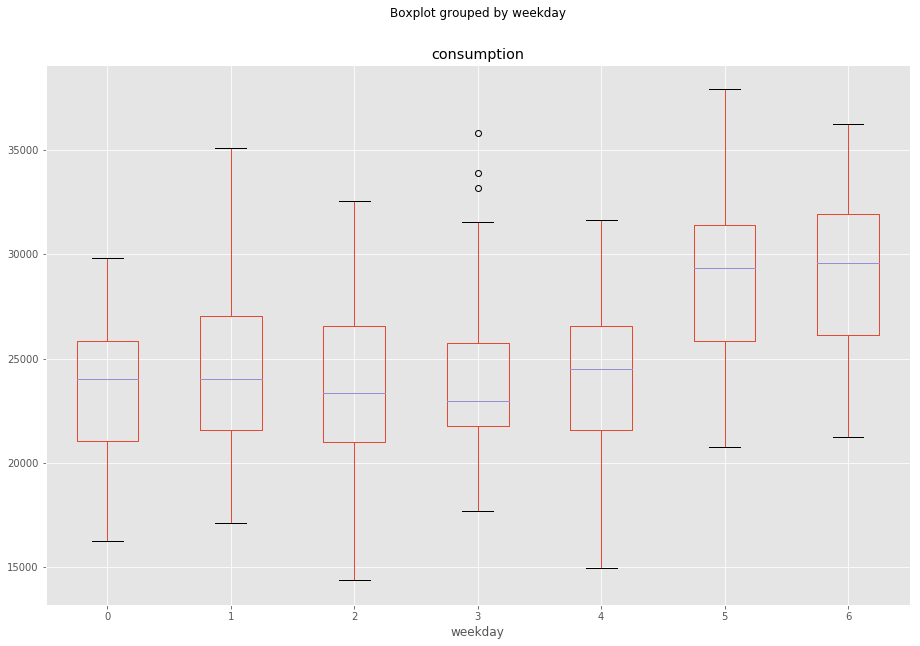

In [11]:
df['weekday'] = df.date.dt.weekday
df.boxplot(column='consumption', by='weekday')

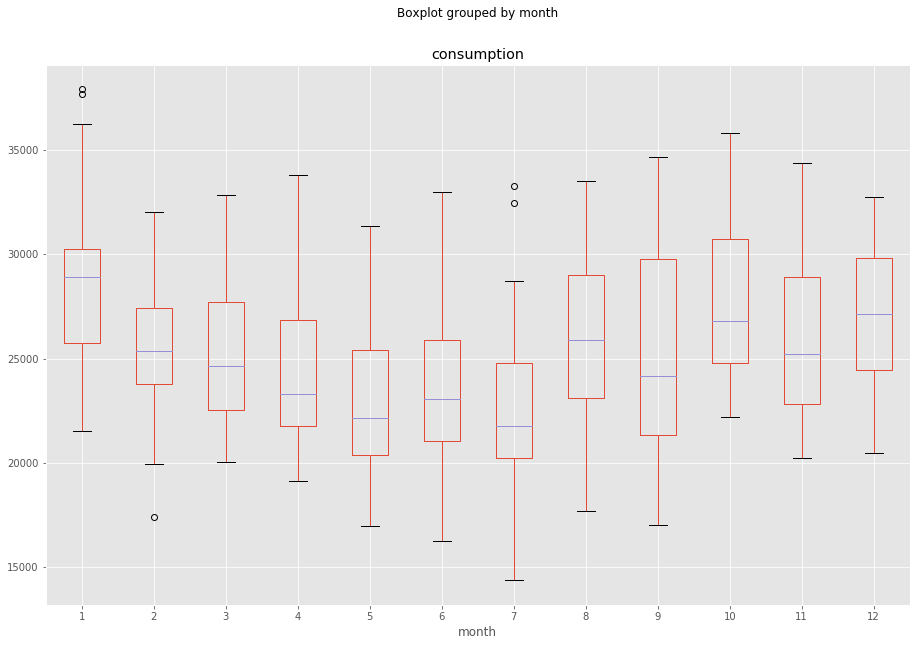

In [13]:
df['month'] = df.date.dt.month
df.boxplot(column='consumption', by='month')

In [14]:
pivoted = df.pivot_table(values='consumption', index='weekday', columns='month')
pivoted

month,1,2,3,4,5,6,7,8,9,10,11,12
weekday,,,,,,,,,,,,
0,26357.00,24798.50,23384.80,22779.50,22355.25,21876.40,20920.75,24648.00,22062.75,25753.00,23122.60,25608.75
1,30076.75,24287.50,24001.00,23731.25,21813.75,21953.80,21659.75,24017.25,24143.00,26070.00,24839.50,25999.20
2,28322.50,24575.25,22122.25,21536.80,20437.50,21050.50,21256.00,24002.75,24724.80,28280.75,24945.25,25121.00
3,25614.60,23011.25,26081.50,21559.80,21228.00,22846.00,21094.20,21070.00,27505.50,27481.20,25161.50,25938.60
4,26485.00,24462.00,23280.50,23927.50,19659.40,21531.25,21700.00,24379.75,24130.25,27393.40,24633.25,28400.75
5,32363.80,29133.50,29081.25,31299.25,25530.00,27004.50,24222.00,31051.20,26278.50,30862.00,28985.00,29130.25
6,31916.25,29444.00,27387.40,29072.50,27493.00,29983.00,28074.50,30160.60,27924.25,27037.75,28995.00,31100.50


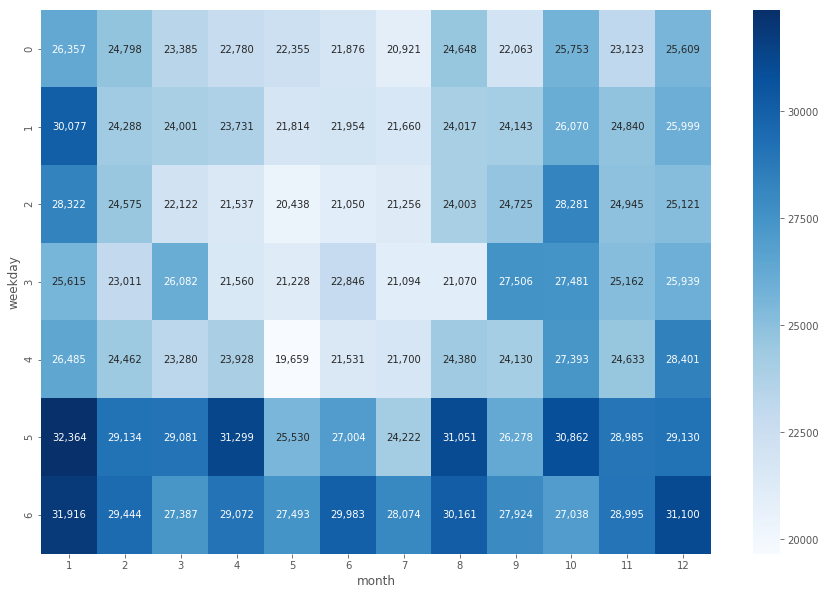

In [17]:
sns.heatmap(pivoted, annot=True, fmt=',.0f', cmap='Blues')